<a href="https://colab.research.google.com/github/benstream/CS-311/blob/main/AKFF_Data_Graphing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import geopandas as gpd
import glob
import os
from matplotlib import colormaps
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Set Drive to directitory and make sure CSV files are there\
%cd /content/drive/Shareddrives/ISER_GINA/Bristol_Bay_Project/Historical\ Data/Fire_Weather_Data/akff_data

%ls

/content/drive/Shareddrives/ISER_GINA/Bristol_Bay_Project/Historical Data/Fire_Weather_Data/akff_data
akff_data_combined.csv             FPKA2_akff_data.csv     P17KX_akff_data.csv  PANW_akff_data.csv
ALSA2_akff_data.csv                KILA2_akff_data.csv     PADL_akff_data.csv   PAPH_akff_data.csv
BLAA2_akff_data.csv                KILA2_akff_data.gsheet  PAIG_akff_data.csv   PAPN_akff_data.csv
CONA2_akff_data.csv                MOGA2_akff_data.csv     PAIL_akff_data.csv   PASD_akff_data.csv
COVA2_akff_data.csv                N15KX_akff_data.csv     PAJC_akff_data.csv   SVRA2_akff_data.csv
earliest_akff_data_by_station.csv  N18KX_akff_data.csv     PAJZ_akff_data.csv
FAFA2_akff_data.csv                O14KX_akff_data.csv     PAKF_akff_data.csv


In [31]:
# Define a function that returns zero if the value is negative, otherwise returns the value itself
def zero_if_negative(value):
    if value < 0:
        return 0
    else:
        return value

# Read in CSV File(s)
path = './' # use your path
all_files = glob.glob(os.path.join(path, "KILA2_akff_data.csv"))
df = pd.concat((pd.read_csv(f, comment='!',low_memory=False) for f in all_files), ignore_index=True)

# Create a list of months to filter (May-Sept)
months = [5, 6, 7, 8, 9]

# 5 year grouper based on timeframe, arbitrary origin date
yearGroup = pd.Grouper(key='DATE', freq='5Y', origin='1970-01-01',label='left')

# Combine files and sort by datetime, now data is ordered, removing rows that have no date, assigning dtypes.
df['DATE'] = pd.to_datetime(df['DATE'],format = "%Y%m%d")
df.loc[:,'PREC'] = df.loc[:,'PREC'].to_numpy(float)
df.loc[:,'PREC'] = df['PREC'].apply(zero_if_negative)
df.loc[:,'WSM'] = df.loc[:,'WSM'].to_numpy(float)

# Calculate the rolling sum of the 'rain_diff' column with a window of 24 & 72 hours
df.loc[:,'day'] = df.loc[:,'DATE'].dt.dayofyear
df.loc[:,'year'] = df.loc[:,'DATE'].dt.year
df.loc[:,'rain_gain_24h'] = df.rolling('24H', on='DATE')['PREC'].sum()
df.loc[:,'rain_gain_72h'] = df.rolling('72H', on='DATE')['PREC'].sum()

# Filter the dataframe by the months after computations
df = df[df['DATE'].dt.month.isin(months)]

# Pivot the data by year and month
df_pivot = pd.pivot_table(df,index='day', columns=yearGroup, values='PREC').cumsum()
#df_pivot.fillna(method='ffill', inplace=True)

# Create Rolling Average for Max wind speed to oivot off of.

df_pivot_maxwind = pd.pivot_table(df,index='day', columns=yearGroup, values='WSM',aggfunc='max')

df_pivot_wind = pd.pivot_table(df,index='day', columns=yearGroup, values='WSM',aggfunc='mean')

# Create Rolling 72 Hour Average and Max wind speed
df.loc[:,'max_windspeed'] = df.rolling('3D', on='DATE')['WSM'].max()
df_pivot_maxwind_72hr = pd.pivot_table(df,index='day', columns=yearGroup, values='max_windspeed')

df.loc[:,'mean_windspeed_72hr'] = df.rolling('3D', on='DATE')['WSM'].mean()
df_pivot_wind_72hr = pd.pivot_table(df,index='day', columns=yearGroup, values='mean_windspeed_72hr')
# Create the Pivots of rain averages
df_pivot_rain24hr = pd.pivot_table(df,index='day', columns=yearGroup, values='rain_gain_24h')
df_pivot_rain72hr = pd.pivot_table(df,index='day', columns=yearGroup, values='rain_gain_72h')

# Create average of solar radiation ((DSR NOT DIRECT SOLAR RADIATION))
df.loc[:,'mean_solar_rad_24hr'] = df.rolling('1D', on='DATE')['DSR'].mean()
df_pivot_solar = pd.pivot_table(df,index='day', columns=yearGroup, values='mean_solar_rad_24hr')

# Create average and max of Build Up Index

df_pivot_bui_mean = pd.pivot_table(df,index='day', columns=yearGroup, values='BUI')
df_pivot_bui_max = pd.pivot_table(df,index='day', columns=yearGroup, values='BUI',aggfunc='max')

# Create average and max of solar radiation

df_pivot_fwi = pd.pivot_table(df,index='day', columns=yearGroup, values='FWI')
df_pivot_fwi_max = pd.pivot_table(df,index='day', columns=yearGroup, values='FWI', aggfunc='max')


In [61]:
print(df.iloc[0].NAME)

KILBUCK


In [62]:
figsize=(16, 8)
nameID = (df.iloc[0].NAME,df.iloc[0].STATIONID)
legend =['1990-1995', '1995-2000', '2000-2005','2005-2010','2010-2015', '2015-2020','2020-']
columns = 4
colormap = "plasma"
lw = 3 #list(colormaps)

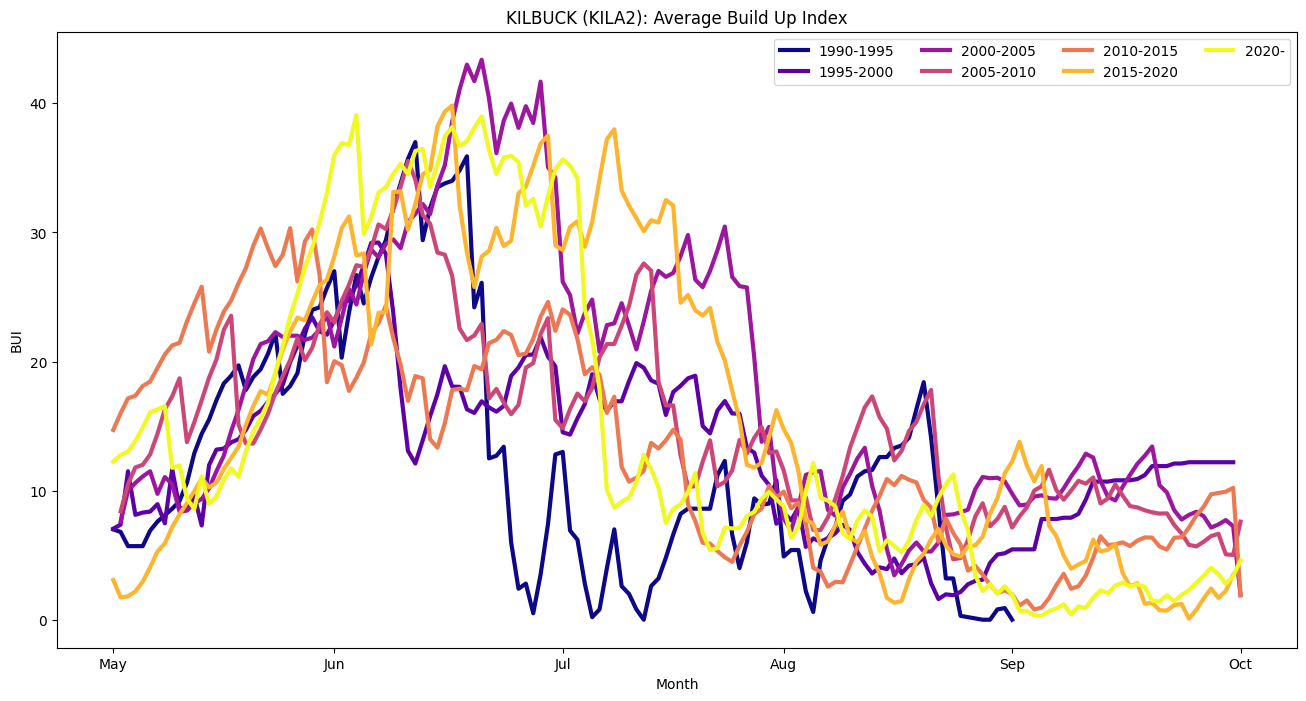

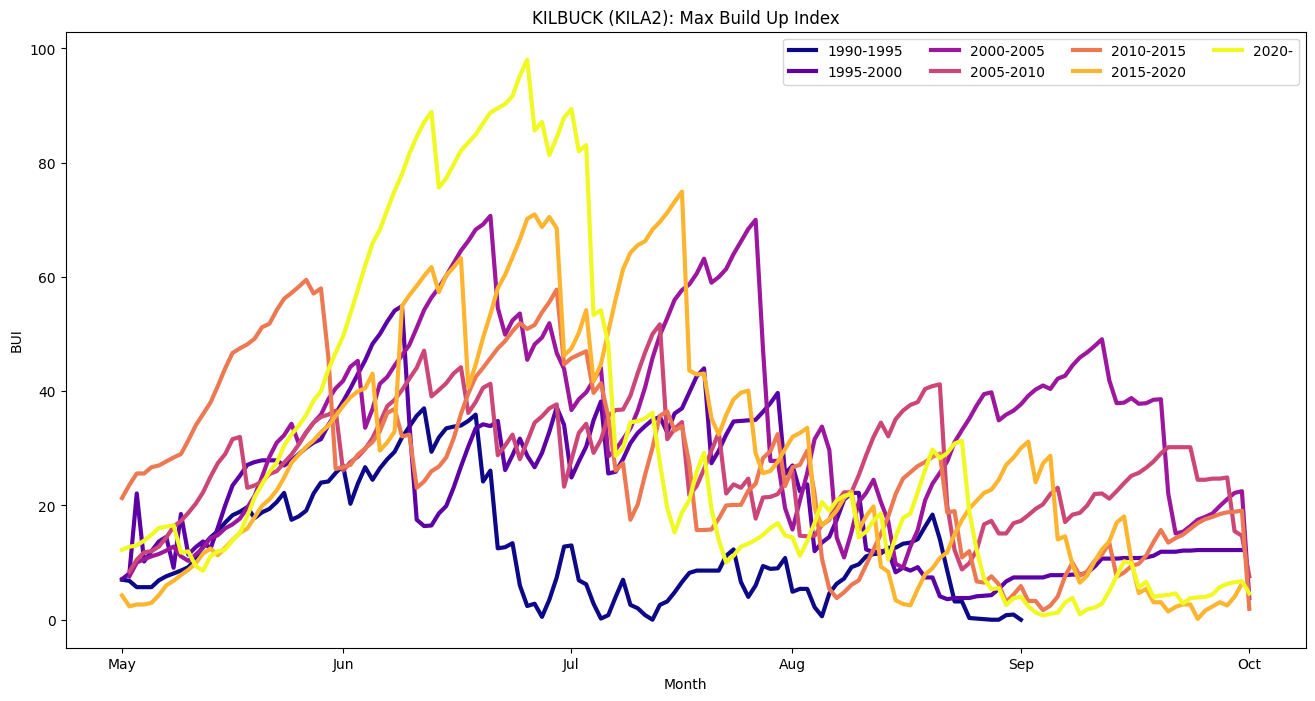

In [66]:
# Plotting, Can clean up into single page
df_pivot_bui_mean.plot(lw=lw,colormap=colormap,ylabel='BUI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Average Build Up Index",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend, ncol = columns)

# Plotting, Can clean up into single page
df_pivot_bui_max.plot(lw=lw,colormap=colormap,ylabel='BUI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Max Build Up Index",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend, ncol = columns)

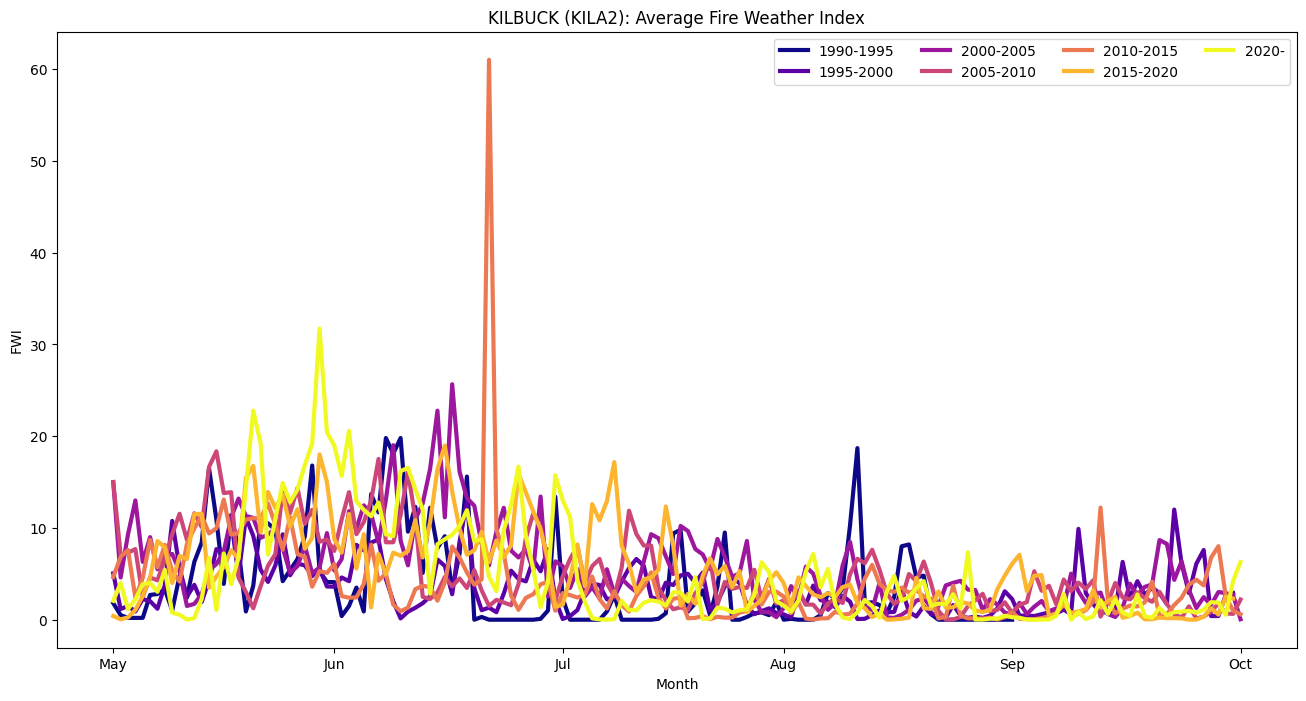

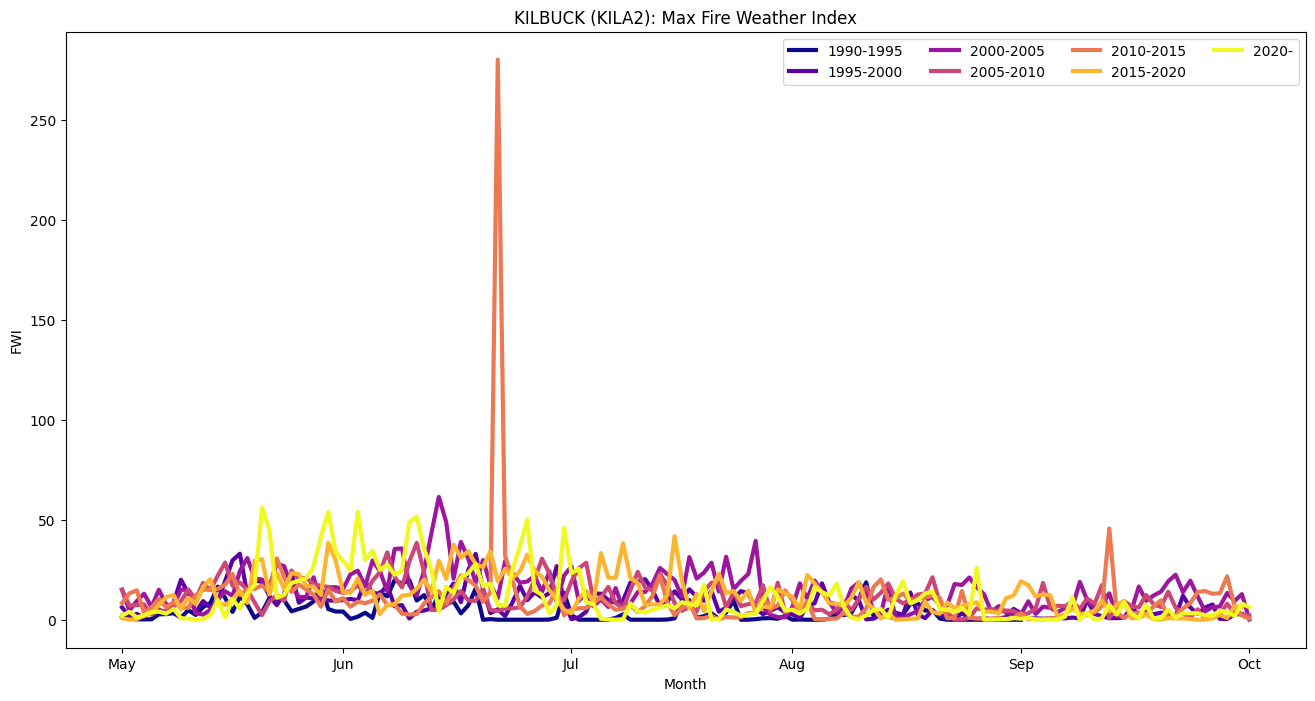

In [67]:
# Plotting, Can clean up into single page NOT SOLAR RADIATION
df_pivot_fwi.plot(lw=lw,colormap=colormap,ylabel='FWI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Average Fire Weather Index",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend, ncol = columns)

df_pivot_fwi_max.plot(lw=lw,colormap=colormap,ylabel='FWI',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Max Fire Weather Index",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend, ncol = columns)

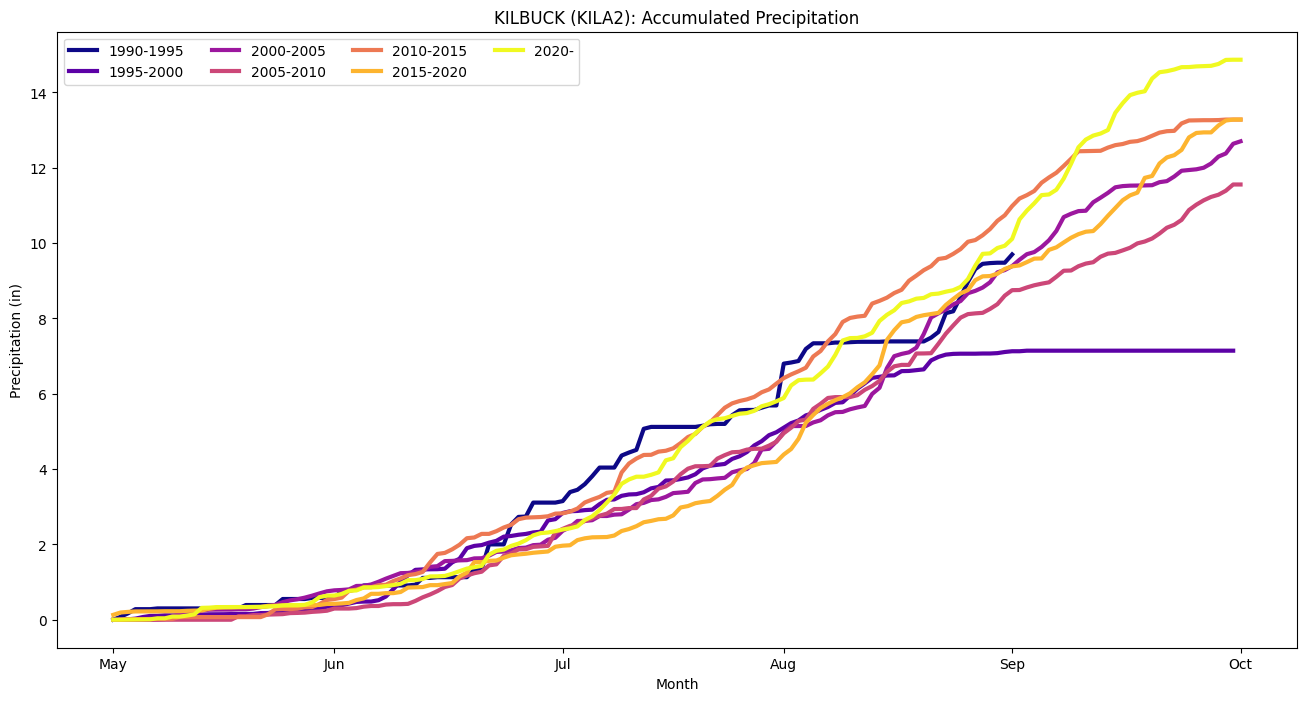

In [68]:
# Accumulated Precipitation Graph, When no data, stop graphing.
df_pivot.plot(lw=3,colormap=colormap,ylabel='Precipitation (in)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): Accumulated Precipitation",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend,loc="upper left", ncol = columns)


In [69]:
# df_pivot_solar.plot(lw=lw,colormap=colormap,ylabel='Solar Radiation (W/m**2)',xlabel='Month',legend='reverse',title="Average Solar Radiation",figsize=figsize)
# plt.xticks(np.linspace(121,274,6)[:-1], ('May','Jun','Jul','Aug','Sep'))
# plt.legend(legend,loc="upper left", ncol = columns)

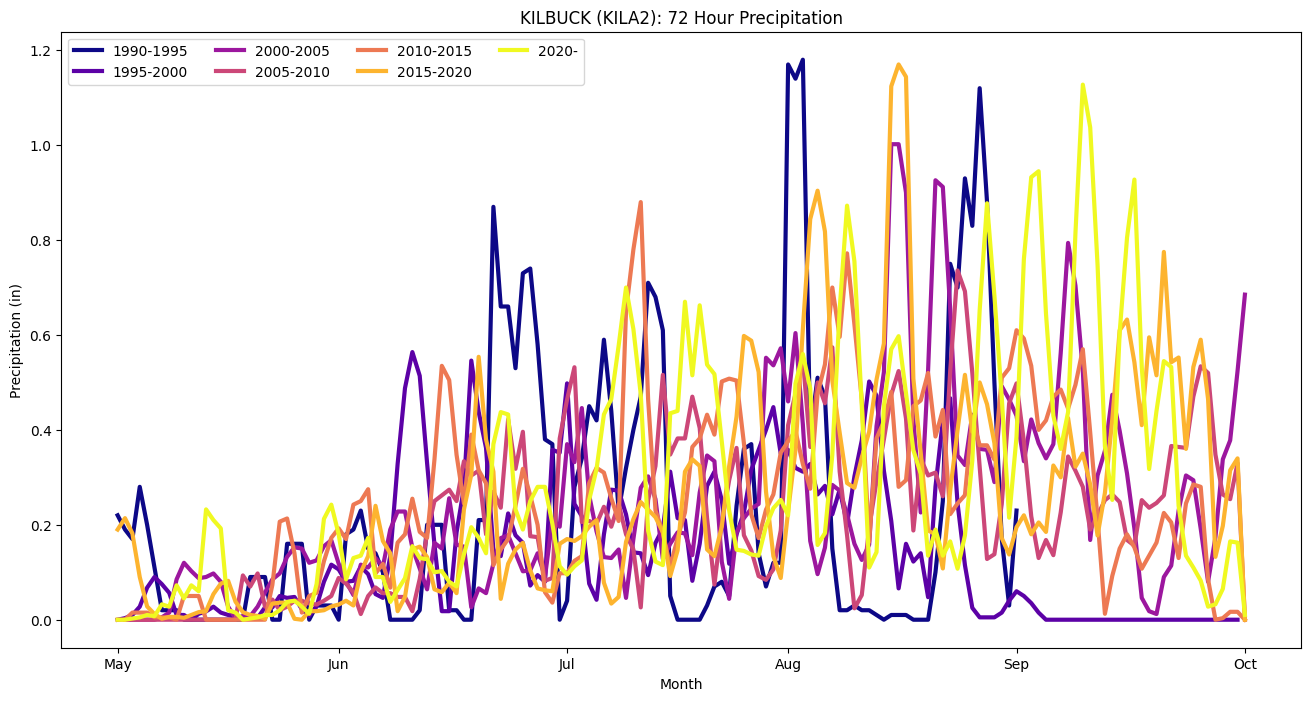

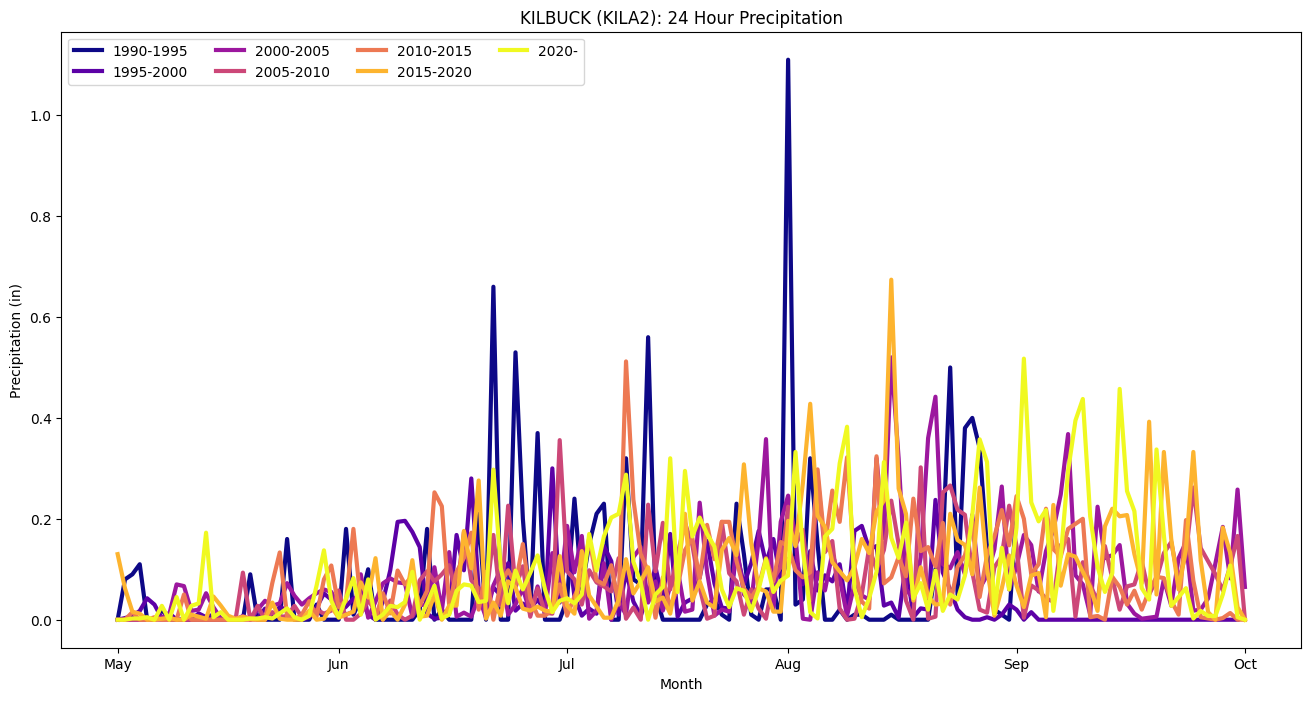

In [70]:
df_pivot_rain72hr.plot(lw=lw,colormap=colormap,ylabel='Precipitation (in)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 72 Hour Precipitation",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend,loc="upper left", ncol = columns)
df_pivot_rain24hr.plot(lw=lw,colormap=colormap,ylabel='Precipitation (in)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 24 Hour Precipitation",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend,loc="upper left", ncol = columns)

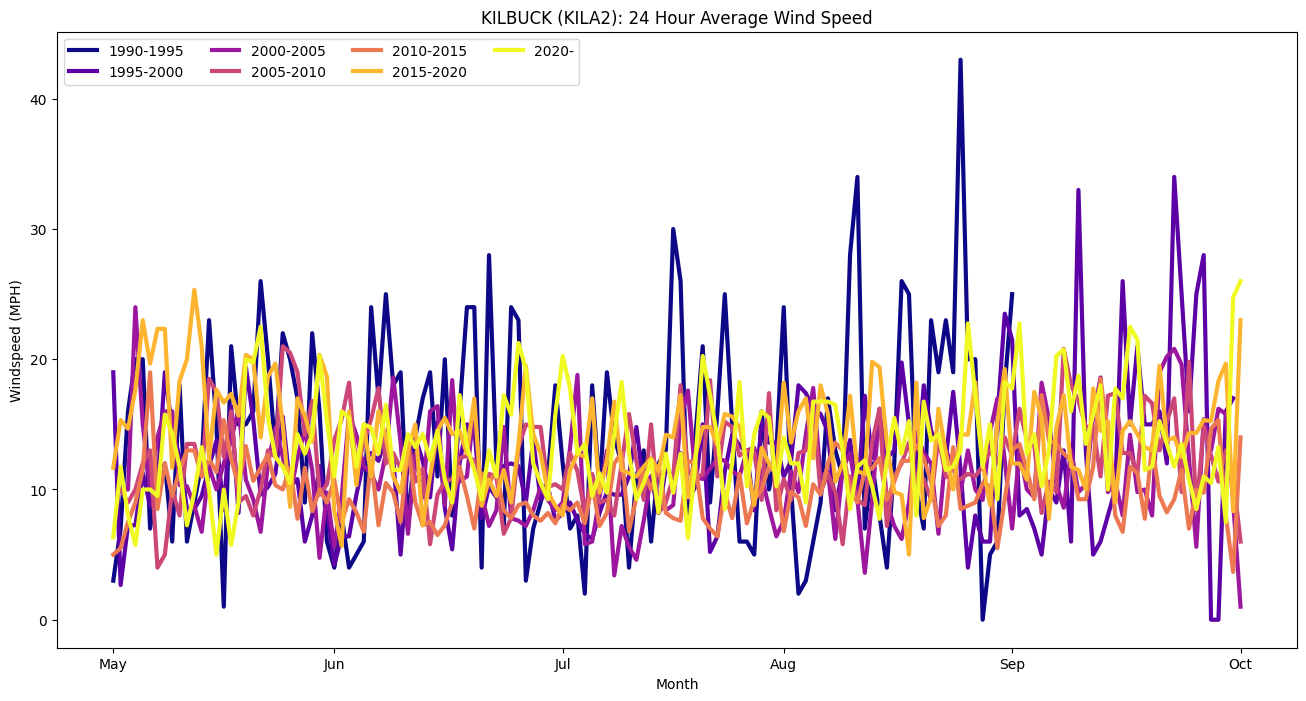

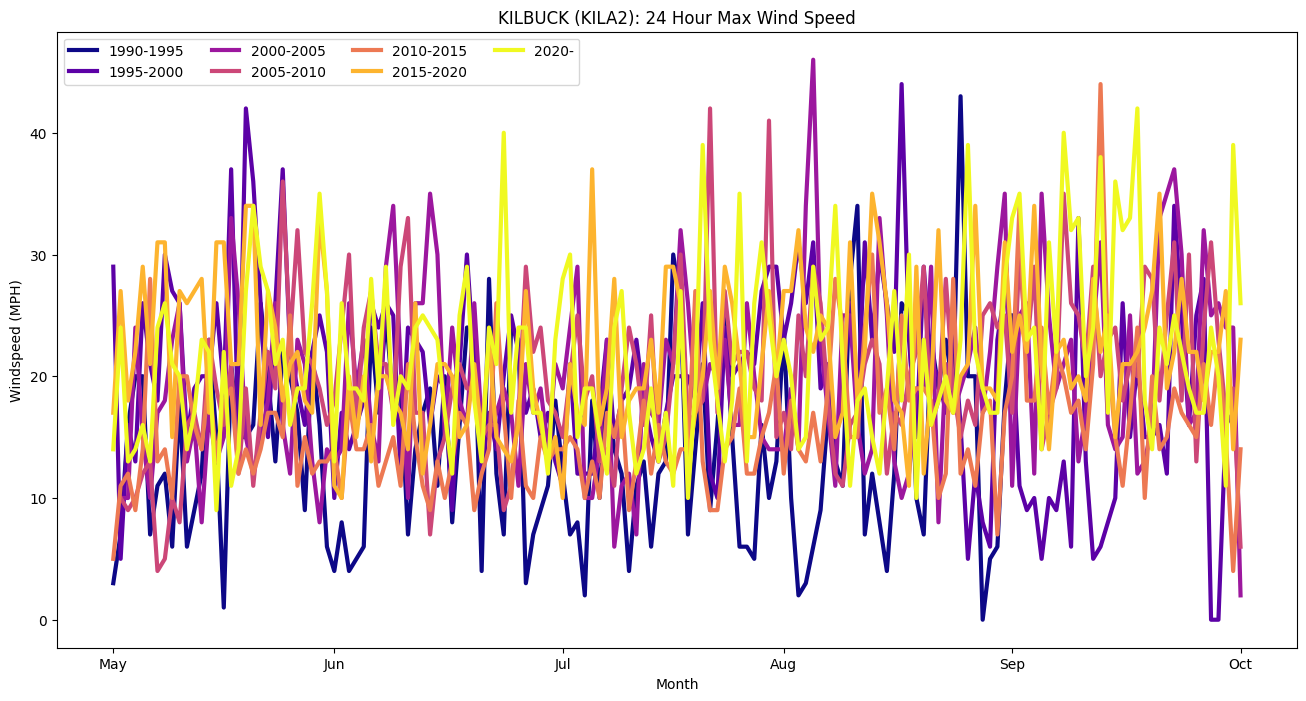

In [71]:
# 24 Hour Max and Average windspeed
df_pivot_wind.plot(lw=lw,colormap=colormap,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 24 Hour Average Wind Speed",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend,loc="upper left", ncol = columns)
df_pivot_maxwind.plot(lw=lw,colormap=colormap,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 24 Hour Max Wind Speed",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend,loc="upper left", ncol = columns)

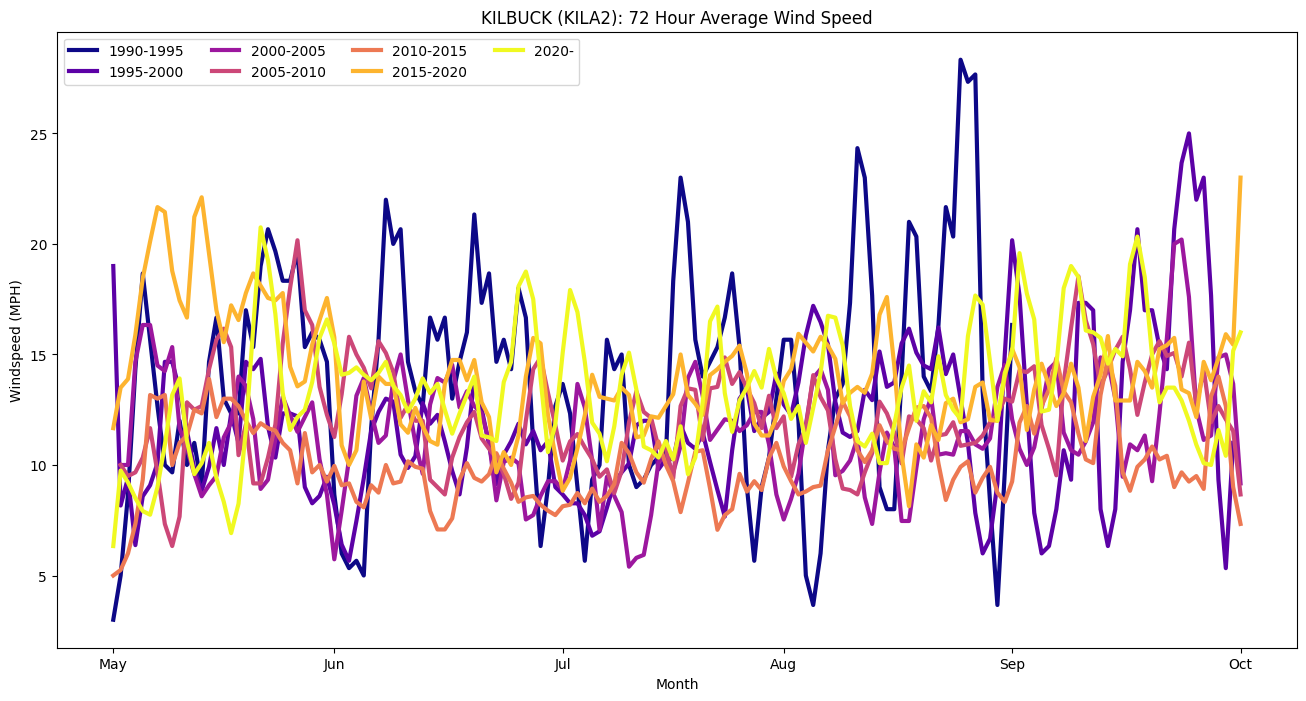

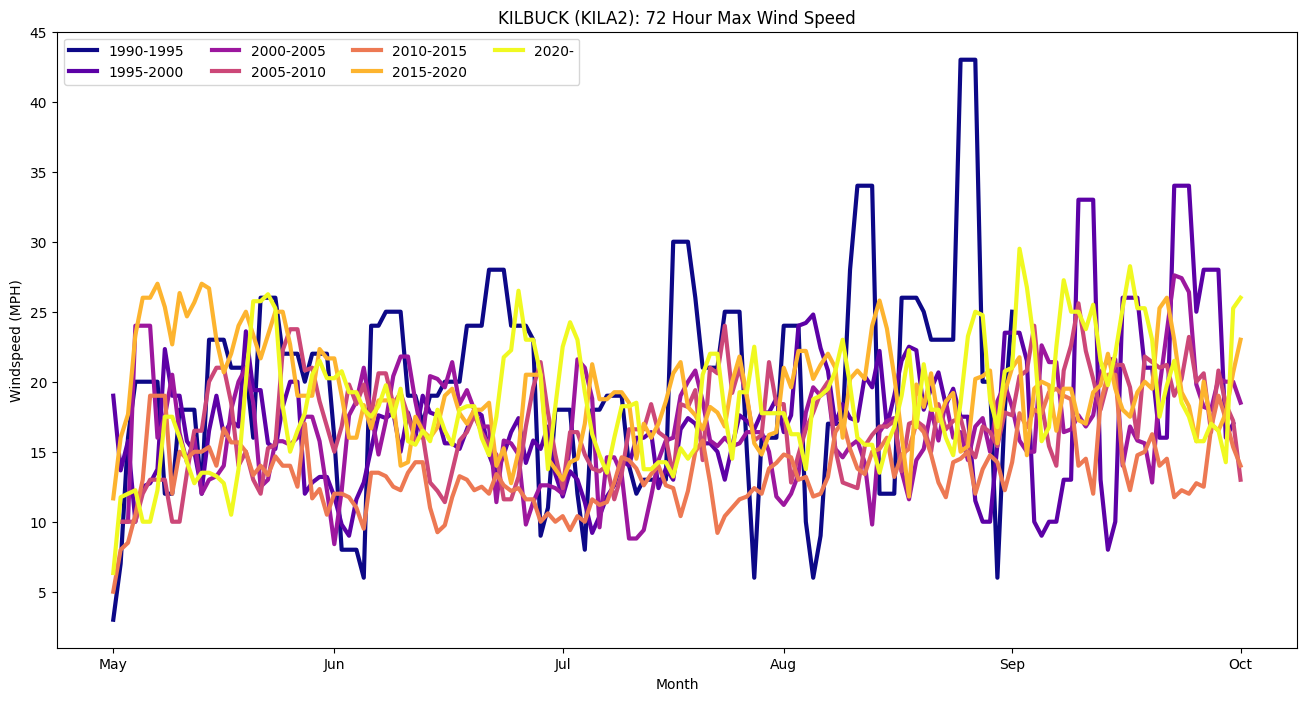

In [72]:
# 72 Hour Rolling Averages and Maxes.
df_pivot_wind_72hr.plot(lw=lw,colormap=colormap,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 72 Hour Average Wind Speed",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend,loc="upper left", ncol = columns)
df_pivot_maxwind_72hr.plot(lw=lw,colormap=colormap,ylabel='Windspeed (MPH)',xlabel='Month',legend='reverse',title=f"{nameID[0]} ({nameID[1]}): 72 Hour Max Wind Speed",figsize=figsize)
plt.xticks([121, 151, 182, 212, 243, 274], ('May','Jun','Jul','Aug','Sep','Oct'))
plt.legend(legend,loc="upper left", ncol = columns)